In [26]:
import numpy as np
import pandas as pd
import csv
import itertools
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import load_model, Model, Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras import backend as K 
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler

In [2]:
pip install gender-guesser

In [6]:
import gender_guesser.detector as gender
d = gender.Detector()

In [7]:
##### Functions for pre-processing

def cbind(data_main, data_1):
  ''' bind columns horizontally like "cbind" in R '''
  data_main.reset_index(drop=True, inplace=True)
  data_1.reset_index(drop=True, inplace=True)
  data_main = pd.concat([data_main, data_1], axis=1)

  return(data_main)

def rbind(data_main, data_1):
  ''' bind rows vertically like "rbind" in R '''
  data_main.reset_index(drop=True, inplace=True)
  data_1.reset_index(drop=True, inplace=True)
  data_main = pd.concat([data_main, data_1], axis=0)

  return(data_main)

def count_entries_trunc(incol, outcol):
  ''' count entries in a given pandas cell where entries are comma delimited'''
  temp = out_comps[incol].str.count('\w+')
  temp = np.where(temp.isnull(), 0, temp)
  temp = pd.Series(temp)
  temp_df = temp.to_frame()
  temp_df.columns = [outcol]

  return(temp_df)


def conv_date_year_days(pref, col):
  ''' convert date info to year and elapsed days info '''
  split_date = out_comps[col].str.split("/", expand=True)
  split_date.columns = [pref+"_month", pref+"_day", pref+"_year"]
  split_date[pref+"_month"] = pd.to_numeric(split_date[pref+"_month"], downcast="float")
  split_date[pref+"_day"] = pd.to_numeric(split_date[pref+"_day"], downcast="float")
  split_date[pref+"_year"] = pd.to_numeric(split_date[pref+"_year"], downcast="float")
  split_date[pref+"_elapsed_days"] = (365*split_date[pref+"_year"]) + (30*split_date[pref+"_month"]) + split_date[pref+"_day"]
  split_date = split_date[[pref+"_year", pref+"_elapsed_days"]]

  return(split_date)


def col_normalizer(in_data, incol, type_norm="mean_sd", min_yr=None):
    ''' normalize input column for input data. if type = "mean_sd"
        calculate z-score. if type == "min_max" subtract min value '''
    if type_norm == "mean_sd":
        outdata = (in_data[incol]-in_data[incol].mean())/in_data[incol].std()
    elif type_norm == "min_max":
        if min_yr is None: 
            outdata = in_data[incol]-in_data[incol].min()
        else:
            outdata = in_data[incol]-min_yr
    
    return(outdata)



In [8]:
### GDPDEF
gdp_def = pd.read_csv('GDPDEF2.csv', encoding = "ISO-8859-1", low_memory=False)
split_date = gdp_def['DATE'].str.split("-", expand=True)
#split_date.tail(5)
split_date.columns = ["gdpdef_year", "gdpdef_day", "gdpdef_month"]
split_date["gdpdef_year"] = pd.to_numeric(split_date["gdpdef_year"], downcast="float")
gdp_def["GDPDEF"] = pd.to_numeric(gdp_def["GDPDEF"], downcast="float")
gdp_def["multiplier"] = 1/(gdp_def["GDPDEF"]/100)
gdp_def = cbind(gdp_def, split_date[["gdpdef_year"]])
gdp_def.head(5)


,DATE,GDPDEF,multiplier,gdpdef_year
0,1980-01-01,42.273998,2.365520,1980.0
1,1981-01-01,46.273750,2.161052,1981.0
2,1982-01-01,49.131748,2.035344,1982.0
3,1983-01-01,51.044750,1.959065,1983.0
4,1984-01-01,52.891750,1.890654,1984.0


In [9]:
### Load company data
out_comps = pd.read_csv('OUT_companies.csv', encoding = "ISO-8859-1", low_memory=False)
out_comps.head(5)


,company_id,company_name_x,familiar_name,previous_name,exchange,ticker,employee_count,year_founded,business_status,ownership_status,...,general_voting.rights,shares_authorized,par_value,dividend_rate,original_price,liquidation,liquidation_pref_mutliple,conversion_price,percent_owned,last_updated_y_y
0,53495-20,29,29 Cosmetics,NaN,NaN,NaN,5.0,2007.0,Generating Revenue,Privately Held (backing),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53874-64,37.5,NaN,TrapTek,NaN,NaN,26.0,2000.0,Generating Revenue,Privately Held (backing),...,Yes,2858436.0,0.001,NaN,0.704478,0.704478,1.0,0.604479,2.840633,12/29/2017
2,53874-64,37.5,NaN,TrapTek,NaN,NaN,26.0,2000.0,Generating Revenue,Privately Held (backing),...,Yes,46899045.0,0.001,NaN,0.428320,0.428320,1.0,0.428320,39.991206,12/29/2017
3,53874-64,37.5,NaN,TrapTek,NaN,NaN,26.0,2000.0,Generating Revenue,Privately Held (backing),...,Yes,31336627.0,0.001,NaN,0.511625,0.511625,1.0,0.511625,25.000000,12/29/2017
4,53874-64,37.5,NaN,TrapTek,NaN,NaN,26.0,2000.0,Generating Revenue,Privately Held (backing),...,Yes,41109410.0,0.001,NaN,0.511625,0.511625,1.0,0.511625,29.411757,12/29/2017


In [10]:
out_comps.drop_duplicates(subset = ['deal_id'], keep="first", inplace=True)
out_comps.shape

(52532, 166)

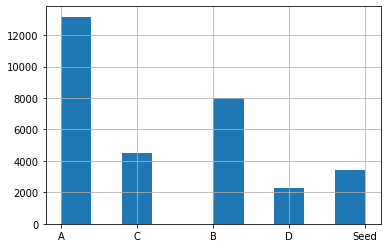

In [11]:
### Frequency of observations by funding round type

out_comps.loc[out_comps.stock_series.isin(["A", "B", "C", "D", "Seed"])]['stock_series'].hist()

In [12]:
# number of unique companies in cleaned dataset

out_comps['company_id'].nunique()

22067

In [13]:
### Announced and deal dates
announced_date = conv_date_year_days('announced', 'announced_date')
deal_date = conv_date_year_days('deal', 'deal_date')
dates_info = cbind(announced_date, deal_date)
dates_info['elapsed_announced_deal'] = deal_date['deal_elapsed_days'] - announced_date['announced_elapsed_days']
out_comps = cbind(out_comps, dates_info[['deal_year','elapsed_announced_deal']])

out_comps.shape

(52532, 168)

In [14]:
### GDP Deflation of monetary values

out_comps = pd.merge(out_comps, gdp_def[['multiplier','gdpdef_year']], 
                           left_on='deal_year', right_on='gdpdef_year', how='left')

### Pre Valuation
out_comps['pre_valuation_deflated'] = out_comps['pre_valuation'] * out_comps['multiplier']
# del out_comps_small['pre_valuation']

### Post Valuation
out_comps['post_valuation_deflated'] = out_comps['post_valuation'] * out_comps['multiplier']

### Raised to Date
out_comps['raised_to_date_deflated'] = out_comps['raised_to_date'] * out_comps['multiplier']

### Deal Size
out_comps['deal_size_deflated'] = out_comps['deal_size'] * out_comps['multiplier']

### Price per Share
out_comps['price_per_share_deflated'] = out_comps['price_per_share_x'] * out_comps['multiplier']

out_comps.head(10)

,company_id,company_name_x,familiar_name,previous_name,exchange,ticker,employee_count,year_founded,business_status,ownership_status,...,last_updated_y_y,deal_year,elapsed_announced_deal,multiplier,gdpdef_year,pre_valuation_deflated,post_valuation_deflated,raised_to_date_deflated,deal_size_deflated,price_per_share_deflated
0,53495-20,29,29 Cosmetics,NaN,NaN,NaN,5.0,2007.0,Generating Revenue,Privately Held (backing),...,NaN,2009.0,NaN,1.052601,2009.0,NaN,NaN,1.473642,1.473642,NaN
1,53874-64,37.5,NaN,TrapTek,NaN,NaN,26.0,2000.0,Generating Revenue,Privately Held (backing),...,12/29/2017,2012.0,6.0,1.000013,2012.0,45.000563,60.000751,48.366605,15.000188,0.511631
2,53874-64,37.5,NaN,TrapTek,NaN,NaN,26.0,2000.0,Generating Revenue,Privately Held (backing),...,12/29/2017,2017.0,37.0,0.928462,2017.0,55.707722,59.189445,48.387720,3.481723,0.475024
3,65227-24,@TheMoment,NaN,NaN,NaN,NaN,NaN,1999.0,Out of Business,Out of Business,...,12/29/2017,1999.0,NaN,1.309492,1999.0,6.547459,7.595053,1.047593,1.047593,1.309492
4,65227-24,@TheMoment,NaN,NaN,NaN,NaN,NaN,1999.0,Out of Business,Out of Business,...,12/29/2017,2000.0,NaN,1.280848,2000.0,20.685701,28.108218,8.447195,7.422516,1.216806
5,65227-24,@TheMoment,NaN,NaN,NaN,NaN,NaN,1999.0,Out of Business,Out of Business,...,12/29/2017,2000.0,NaN,1.280848,2000.0,57.638177,70.446661,21.255680,12.808484,2.305527
6,65227-24,@TheMoment,NaN,NaN,NaN,NaN,NaN,1999.0,Out of Business,Out of Business,...,12/29/2017,2001.0,NaN,1.253294,2001.0,14.838998,23.902530,29.861942,9.063532,0.370975
7,51557-68,0-In Design Automation,NaN,NaN,NaN,NaN,41.0,1996.0,Generating Revenue,Acquired/Merged,...,12/29/2017,1996.0,NaN,1.366508,1996.0,4.728116,6.697595,1.969484,1.969479,1.366508
8,51557-68,0-In Design Automation,NaN,NaN,NaN,NaN,41.0,1996.0,Generating Revenue,Acquired/Merged,...,12/29/2017,1998.0,NaN,1.328387,1998.0,18.881218,22.717348,5.750679,3.836130,3.852323
9,51557-68,0-In Design Automation,NaN,NaN,NaN,NaN,41.0,1996.0,Generating Revenue,Acquired/Merged,...,12/29/2017,1999.0,NaN,1.309492,1999.0,31.120231,39.557563,14.106213,8.437331,5.277252


In [15]:
### Identify first and last rounds of funding for each company in the dataset

unique_companies = out_comps.company_id.unique()


comp_to_minr = {}
for company in unique_companies: # loop through unique companies
    temp_df = out_comps.loc[out_comps['company_id'] == company][['deal_number']] # subset full
    rounds = temp_df.deal_number.unique()
    r_min = np.nanmin(rounds)
    r_max = np.nanmax(rounds)
    comp_to_minr[company] = (r_min, r_max)
    
comp_to_minr

/Users/abe_quals/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: All-NaN slice encountered
  # Remove the CWD from sys.path while we load stuff.
/Users/abe_quals/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: All-NaN slice encountered
  # This is added back by InteractiveShellApp.init_path()


{'53495-20': (1.0, 1.0),
 '53874-64': (4.0, 5.0),
 '65227-24': (1.0, 4.0),
 '51557-68': (1.0, 4.0),
 '61202-08': (1.0, 1.0),
 '161843-77': (1.0, 1.0),
 '54218-98': (1.0, 1.0),
 '60318-10': (1.0, 5.0),
 '184598-29': (nan, nan),
 '187815-52': (nan, nan),
 '97826-14': (1.0, 1.0),
 '60518-80': (1.0, 1.0),
 '105743-98': (1.0, 5.0),
 '60258-70': (2.0, 3.0),
 '51151-96': (2.0, 8.0),
 '52141-15': (1.0, 2.0),
 '55941-94': (3.0, 3.0),
 '53663-77': (1.0, 1.0),
 '109105-48': (1.0, 2.0),
 '104281-03': (1.0, 3.0),
 '85547-44': (1.0, 2.0),
 '97207-93': (1.0, 3.0),
 '97267-96': (1.0, 4.0),
 '81686-53': (1.0, 1.0),
 '160553-53': (2.0, 2.0),
 '104389-03': (nan, nan),
 '54677-17': (1.0, 1.0),
 '53330-68': (1.0, 4.0),
 '222925-60': (1.0, 1.0),
 '57743-02': (2.0, 3.0),
 '61318-09': (nan, nan),
 '63413-38': (2.0, 4.0),
 '183062-80': (1.0, 1.0),
 '55223-38': (1.0, 2.0),
 '51081-40': (1.0, 10.0),
 '81740-44': (1.0, 2.0),
 '50848-93': (1.0, 6.0),
 '55301-41': (1.0, 1.0),
 '81672-40': (1.0, 3.0),
 '54434-62': (

In [16]:
# Calculate valuation step-up multiple (output variable)

out_comps['valuation_growth'] =  (out_comps['post_valuation_deflated']  / out_comps['post_valuation_deflated'].shift(1))

out_comps[['company_id', 'deal_number', 'post_valuation_deflated', 'valuation_growth']].head(30)

,company_id,deal_number,post_valuation_deflated,valuation_growth
0,53495-20,1.0,NaN,NaN
1,53874-64,4.0,60.000751,NaN
2,53874-64,5.0,59.189445,0.986478
3,65227-24,1.0,7.595053,0.128318
4,65227-24,2.0,28.108218,3.700859
5,65227-24,3.0,70.446661,2.506266
6,65227-24,4.0,23.902530,0.339300
7,51557-68,1.0,6.697595,0.280204
8,51557-68,2.0,22.717348,3.391867
9,51557-68,3.0,39.557563,1.741293


In [17]:
# replace minimum round valuation_growth value with 0 for each company

for company in unique_companies: # loop through unique companies
    # replace replace minimum round valuation_growth value with 0 for each company
    out_comps.loc[((out_comps.company_id==company) & (out_comps.deal_number == comp_to_minr[company][0])), 
              'valuation_growth'] = np.nan
    # replace companies that fail with valuation_growth of 0 in their final round
    out_comps.loc[((out_comps.company_id==company) & (out_comps.deal_number == comp_to_minr[company][1]) &
                  (out_comps.business_status=="Out of Business")|(out_comps.business_status=="Bankruptcy: Admin/Reorg")|(out_comps.business_status=="Bankruptcy: Liquidation")), 'valuation_growth'] = 0
    
out_comps[['company_id', 'deal_number', 'post_valuation', 'valuation_growth']].head(30)

,company_id,deal_number,post_valuation,valuation_growth
0,53495-20,1.0,NaN,NaN
1,53874-64,4.0,60.00000,NaN
2,53874-64,5.0,63.74999,0.986478
3,65227-24,1.0,5.80000,NaN
4,65227-24,2.0,21.94500,3.700859
5,65227-24,3.0,55.00000,2.506266
6,65227-24,4.0,19.07177,0.000000
7,51557-68,1.0,4.90125,NaN
8,51557-68,2.0,17.10145,3.391867
9,51557-68,3.0,30.20833,1.741293


In [18]:
print(out_comps.columns)
print(out_comps.shape)

Index(['company_id', 'company_name_x', 'familiar_name', 'previous_name',
       'exchange', 'ticker', 'employee_count', 'year_founded',
       'business_status', 'ownership_status',
       ...
       'deal_year', 'elapsed_announced_deal', 'multiplier', 'gdpdef_year',
       'pre_valuation_deflated', 'post_valuation_deflated',
       'raised_to_date_deflated', 'deal_size_deflated',
       'price_per_share_deflated', 'valuation_growth'],
      dtype='object', length=176)
(52532, 176)


In [19]:
#subset for initial un-processed columns


as_is_cols = ["employee_count", "year_founded", "deal_number", "percent_owned", 'deal_year','elapsed_announced_deal',
              "percent_acquired", 'pre_valuation_deflated', 'raised_to_date_deflated', 'deal_size_deflated', 
              'price_per_share_deflated',
              'post_valuation_deflated', 'valuation_growth']


out_comps_small = out_comps[as_is_cols]

out_comps_small.shape


(52532, 13)

In [20]:
# state var to int
out_comps["state"] = np.where(out_comps['state'].isnull(), 0, out_comps['state'])
out_comps['state'] = out_comps['state'].astype(int)
out_comps['state'].dtypes


dtype('int64')

In [21]:
##### Preprocessing (One Hot Encodings)

one_hot_cols = ["business_status", "ownership_status", "financing_status", "universe", "sic_codes", 
                "naics_codes", "state", "stock_type_x", "state", 
                'deal_status', 'deal_class', 'stock_series']

for cols in one_hot_cols:
  print(cols)
  temp = pd.get_dummies(out_comps[cols], prefix=cols)

  # index reset necessary for concat
  out_comps_small = cbind(out_comps_small, temp)

out_comps_small.shape

out_comps_small.head(20)



business_status
ownership_status
financing_status
universe
sic_codes
naics_codes
state
stock_type_x
state
deal_status
deal_class
stock_series


,employee_count,year_founded,deal_number,percent_owned,deal_year,elapsed_announced_deal,percent_acquired,pre_valuation_deflated,raised_to_date_deflated,deal_size_deflated,...,stock_series_G,stock_series_H,stock_series_I,stock_series_J,stock_series_K,stock_series_Other,stock_series_Seed,stock_series_Series 1,stock_series_Series 2,stock_series_Series 3
0,5.0,2007.0,1.0,NaN,2009.0,NaN,NaN,NaN,1.473642,1.473642,...,0,0,0,0,0,0,0,0,0,0
1,26.0,2000.0,4.0,2.840633,2012.0,6.0,25.00,45.000563,48.366605,15.000188,...,0,0,0,0,0,0,0,0,0,0
2,26.0,2000.0,5.0,29.411757,2017.0,37.0,5.88,55.707722,48.387720,3.481723,...,0,0,0,0,0,0,0,0,0,0
3,NaN,1999.0,1.0,13.793103,1999.0,NaN,13.79,6.547459,1.047593,1.047593,...,0,0,0,0,0,0,0,0,0,0
4,NaN,1999.0,2.0,8.658009,2000.0,NaN,26.41,20.685701,8.447195,7.422516,...,0,0,0,0,0,0,0,0,0,0
5,NaN,1999.0,3.0,18.181819,2000.0,NaN,18.18,57.638177,21.255680,12.808484,...,0,0,0,0,0,0,0,0,0,0
6,NaN,1999.0,4.0,39.111213,2001.0,NaN,37.92,14.838998,29.861942,9.063532,...,0,0,0,0,0,0,0,0,0,0
7,41.0,1996.0,1.0,29.405821,1996.0,NaN,29.41,4.728116,1.969484,1.969479,...,0,0,0,0,0,0,0,0,0,0
8,41.0,1996.0,2.0,24.440246,1998.0,NaN,16.89,18.881218,5.750679,3.836130,...,0,0,0,0,0,0,0,0,0,0
9,41.0,1996.0,3.0,13.284633,1999.0,NaN,21.33,31.120231,14.106213,8.437331,...,0,0,0,0,0,0,0,0,0,0


In [22]:
##### Preprocessing (Binary/Tertiary Conversions)

### website
out_comps["website"] = np.where(out_comps['website'].isnull(), 0, 1)
out_comps_small = cbind(out_comps_small, out_comps["website"])

### Parent company
out_comps["parent_company"] = np.where(out_comps['parent_company'].isnull(), 0, 1)
out_comps_small = cbind(out_comps_small, out_comps["parent_company"])

### City
out_comps["tech_hotspot"] = np.where(out_comps['city'].isin(["New York", "San Francisco", "San Mateo", "San Jose",
                                                   "Menlo Park", "Mountain View", "Boston",
                                                   "Cambridge", "Seattle", "Berkeley", "Palo Alto",
                                                   "Stanford", "Chicago", "Sunnyvale", "Redwood City",
                                                   "South San Francisco", "Millbrae", "Austin",
                                                   "Evanston", "Raleigh", "Durham", "Cupertino"]), 1, 0)
out_comps_small = cbind(out_comps_small, out_comps["tech_hotspot"])

### Country
out_comps["country_binary"] = np.where(out_comps['country'].isin(["United States"]), 1, 0)
out_comps_small = cbind(out_comps_small, out_comps["country_binary"])

### Post Valuation Status
out_comps["post_valuation_status_actual"] = np.where(out_comps['post_valuation_status'].isin(["Actual"]), 1, 0)
out_comps_small = cbind(out_comps_small, out_comps["post_valuation_status_actual"])

### Gender
ceo_gender_list = []
for index, row in out_comps.iterrows():
  nme = row["ceo_first_name"]
  gender = d.get_gender(nme)
  # print(gender)
  ceo_gender_list.append(gender)

ceo_gender_series=pd.Series(ceo_gender_list, name="ceo_gender_series").astype(str)

# convert to female (1), unknown/androgynous (0), male (-1)
ceo_gender_series = np.where(ceo_gender_series.isin(["female", "mostly_female"]), 1, ceo_gender_series)
ceo_gender_series=pd.Series(ceo_gender_series).astype(str)
ceo_gender_series = np.where(ceo_gender_series.isin(["unknown", "andy"]), 0, ceo_gender_series)
ceo_gender_series=pd.Series(ceo_gender_series).astype(str)
ceo_gender_series = np.where(ceo_gender_series.isin(["male", "mostly_male"]), -1, ceo_gender_series)
ceo_gender_series=pd.Series(ceo_gender_series).astype(str)

ceo_gender_df = ceo_gender_series.to_frame()
ceo_gender_df.columns = ["ceo_name_gender"]
out_comps_small = cbind(out_comps_small, ceo_gender_df)

### Board Voting Rights
out_comps["board_voting_rights_yes"] = np.where(out_comps['board_voting_rights'].isin(["Yes"]), 1, 0)
out_comps_small = cbind(out_comps_small, out_comps["board_voting_rights_yes"])

out_comps_small.shape

out_comps_small.head(10)



,employee_count,year_founded,deal_number,percent_owned,deal_year,elapsed_announced_deal,percent_acquired,pre_valuation_deflated,raised_to_date_deflated,deal_size_deflated,...,stock_series_Series 1,stock_series_Series 2,stock_series_Series 3,website,parent_company,tech_hotspot,country_binary,post_valuation_status_actual,ceo_name_gender,board_voting_rights_yes
0,5.0,2007.0,1.0,NaN,2009.0,NaN,NaN,NaN,1.473642,1.473642,...,0,0,0,1,0,0,1,0,1,0
1,26.0,2000.0,4.0,2.840633,2012.0,6.0,25.00,45.000563,48.366605,15.000188,...,0,0,0,1,0,0,1,1,-1,1
2,26.0,2000.0,5.0,29.411757,2017.0,37.0,5.88,55.707722,48.387720,3.481723,...,0,0,0,1,0,0,1,1,-1,1
3,NaN,1999.0,1.0,13.793103,1999.0,NaN,13.79,6.547459,1.047593,1.047593,...,0,0,0,1,0,1,1,1,-1,1
4,NaN,1999.0,2.0,8.658009,2000.0,NaN,26.41,20.685701,8.447195,7.422516,...,0,0,0,1,0,1,1,1,0,1
5,NaN,1999.0,3.0,18.181819,2000.0,NaN,18.18,57.638177,21.255680,12.808484,...,0,0,0,1,0,1,1,1,0,1
6,NaN,1999.0,4.0,39.111213,2001.0,NaN,37.92,14.838998,29.861942,9.063532,...,0,0,0,1,0,1,1,1,-1,1
7,41.0,1996.0,1.0,29.405821,1996.0,NaN,29.41,4.728116,1.969484,1.969479,...,0,0,0,1,0,1,1,1,1,1
8,41.0,1996.0,2.0,24.440246,1998.0,NaN,16.89,18.881218,5.750679,3.836130,...,0,0,0,1,0,1,1,1,0,1
9,41.0,1996.0,3.0,13.284633,1999.0,NaN,21.33,31.120231,14.106213,8.437331,...,0,0,0,1,0,1,1,1,0,1


In [23]:
##### Preprocessing (Count Conversions)

## Old and new columns
old_cols = ['sister_companies', 'subsidiary_companies', 'customers', 'market', 'competition', 'products']

new_cols = ['sister_companies_count', 'subsidiary_companies_count', 'customers_count', 'market_count',
            'competition', 'products']

## Loop through old/new columns, count the entries per row, add new counts to out_comps_small data set
for i in range(len(old_cols)):
  print(old_cols[i])
  new_col = count_entries_trunc(old_cols[i], new_cols[i])
  out_comps_small = cbind(out_comps_small, new_col)


out_comps_small.shape

sister_companies
subsidiary_companies
customers
market
competition
products


(52532, 641)

In [25]:
out_comps_small.head(10)


,employee_count,year_founded,deal_number,percent_owned,deal_year,elapsed_announced_deal,percent_acquired,pre_valuation_deflated,raised_to_date_deflated,deal_size_deflated,...,country_binary,post_valuation_status_actual,ceo_name_gender,board_voting_rights_yes,sister_companies_count,subsidiary_companies_count,customers_count,market_count,competition,products
0,5.0,2007.0,1.0,NaN,2009.0,NaN,NaN,NaN,1.473642,1.473642,...,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
1,26.0,2000.0,4.0,2.840633,2012.0,6.0,25.00,45.000563,48.366605,15.000188,...,1,1,-1,1,0.0,0.0,0.0,0.0,1.0,0.0
2,26.0,2000.0,5.0,29.411757,2017.0,37.0,5.88,55.707722,48.387720,3.481723,...,1,1,-1,1,0.0,0.0,0.0,0.0,1.0,0.0
3,NaN,1999.0,1.0,13.793103,1999.0,NaN,13.79,6.547459,1.047593,1.047593,...,1,1,-1,1,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,1999.0,2.0,8.658009,2000.0,NaN,26.41,20.685701,8.447195,7.422516,...,1,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0
5,NaN,1999.0,3.0,18.181819,2000.0,NaN,18.18,57.638177,21.255680,12.808484,...,1,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0
6,NaN,1999.0,4.0,39.111213,2001.0,NaN,37.92,14.838998,29.861942,9.063532,...,1,1,-1,1,0.0,0.0,0.0,0.0,0.0,0.0
7,41.0,1996.0,1.0,29.405821,1996.0,NaN,29.41,4.728116,1.969484,1.969479,...,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0
8,41.0,1996.0,2.0,24.440246,1998.0,NaN,16.89,18.881218,5.750679,3.836130,...,1,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0
9,41.0,1996.0,3.0,13.284633,1999.0,NaN,21.33,31.120231,14.106213,8.437331,...,1,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
### Normalization

norm_cols = ['sister_companies_count', 'subsidiary_companies_count', 'customers_count', 
             'market_count', 'competition', 'products', 'pre_valuation_deflated', 'elapsed_announced_deal',
             'raised_to_date_deflated', 'deal_size_deflated', "employee_count",
             'percent_acquired', 'percent_owned', 'price_per_share_deflated']

out_comps_small[norm_cols] = StandardScaler().fit_transform(out_comps_small[norm_cols])
        
### Years - Min
l_deal_year = list(out_comps_small['deal_year'])
l_year_founded = list(out_comps_small['year_founded'])
l_deal_year.extend(l_year_founded)
min_year = min(l_deal_year)
norm_cols2 = ['deal_year', 'year_founded']

for i in range(len(norm_cols2)):
    out_comps_small[norm_cols2[i]] = out_comps_small[norm_cols2[i]] - min_year

out_comps_small.head(10)


,employee_count,year_founded,deal_number,percent_owned,deal_year,elapsed_announced_deal,percent_acquired,pre_valuation_deflated,raised_to_date_deflated,deal_size_deflated,...,country_binary,post_valuation_status_actual,ceo_name_gender,board_voting_rights_yes,sister_companies_count,subsidiary_companies_count,customers_count,market_count,competition,products
0,-0.188402,101.0,1.0,NaN,103.0,NaN,NaN,NaN,-0.212245,-0.251590,...,1,0,1,0,-0.129113,-0.170347,-0.114376,-0.06505,-0.477607,-0.102548
1,-0.163852,94.0,4.0,0.003226,106.0,-0.628359,-0.070973,-0.034653,0.164825,0.052542,...,1,1,-1,1,-0.129113,-0.170347,-0.114376,-0.06505,-0.076628,-0.102548
2,-0.163852,94.0,5.0,0.006834,111.0,-0.514165,-1.289788,-0.019053,0.164995,-0.206440,...,1,1,-1,1,-0.129113,-0.170347,-0.114376,-0.06505,-0.076628,-0.102548
3,NaN,93.0,1.0,0.004713,93.0,NaN,-0.785560,-0.090677,-0.215671,-0.261169,...,1,1,-1,1,-0.129113,-0.170347,-0.114376,-0.06505,-0.477607,-0.102548
4,NaN,93.0,2.0,0.004016,94.0,NaN,0.018908,-0.070078,-0.156170,-0.117835,...,1,1,0,1,-0.129113,-0.170347,-0.114376,-0.06505,-0.477607,-0.102548
5,NaN,93.0,3.0,0.005309,94.0,NaN,-0.505718,-0.016240,-0.053176,0.003264,...,1,1,0,1,-0.129113,-0.170347,-0.114376,-0.06505,-0.477607,-0.102548
6,NaN,93.0,4.0,0.008151,95.0,NaN,0.752619,-0.078597,0.016027,-0.080938,...,1,1,-1,1,-0.129113,-0.170347,-0.114376,-0.06505,-0.477607,-0.102548
7,-0.146316,90.0,1.0,0.006833,90.0,NaN,0.210145,-0.093328,-0.208258,-0.240441,...,1,1,1,1,-0.129113,-0.170347,-0.114376,-0.06505,-0.477607,-0.102548
8,-0.146316,90.0,2.0,0.006159,92.0,NaN,-0.587949,-0.072707,-0.177853,-0.198471,...,1,1,0,1,-0.129113,-0.170347,-0.114376,-0.06505,-0.477607,-0.102548
9,-0.146316,90.0,3.0,0.004644,93.0,NaN,-0.304919,-0.054876,-0.110666,-0.095018,...,1,1,0,1,-0.129113,-0.170347,-0.114376,-0.06505,-0.477607,-0.102548


In [ ]:
out_comps_small.shape

In [28]:
# drop duplicates
out_comps_small.drop_duplicates(keep="first", inplace=True)

out_comps_small.shape



(46328, 641)

In [29]:
### Convert all columns to float
for col in out_comps_small.columns:
  out_comps_small[col] = out_comps_small[col].astype(float)
print("converted")



converted


In [30]:
### Simple imputation: replace NaN's with median column values

for col in out_comps_small.loc[:, out_comps_small.columns != 'valuation_growth'].columns:
    out_comps_small[col] = out_comps_small[col].fillna(out_comps_small[col].median(skipna=True))

out_comps_small.shape


(46328, 641)

In [31]:
# drop nans

out_comps_small = out_comps_small.dropna()
out_comps_small.shape

(23463, 641)

In [32]:
# create outcome data variable

Y = out_comps_small['valuation_growth']

Y.quantile([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1])

0.00      0.000000
0.01      0.000000
0.05      0.000000
0.10      0.095112
0.25      1.079937
0.50      1.666346
0.75      2.605188
0.90      4.070801
0.95      5.628304
0.99     12.380771
1.00    591.433523
Name: valuation_growth, dtype: float64

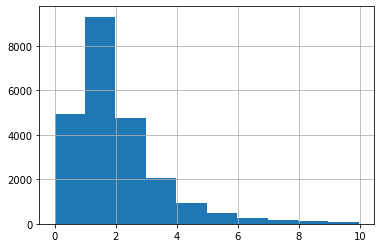

In [33]:
# Plot Y distribution

out_comps_small.loc[out_comps_small.valuation_growth < 10]['valuation_growth'].hist()


In [34]:
Y = np.where(Y > 15, 15, Y)


np.quantile(Y, [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1])


array([ 0.        ,  0.        ,  0.        ,  0.09511203,  1.07993701,
        1.66634559,  2.605188  ,  4.07080129,  5.62830381, 12.3807708 ,
       15.        ])

In [35]:
Y = np.log(Y + 0.001)

np.quantile(Y, [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1])

array([-6.90775528, -6.90775528, -6.90775528, -2.34224206,  0.07782827,
        0.5112329 ,  0.95788862,  1.40408547,  1.72798577,  2.51622528,
        2.70811687])

(array([2.2790e+03, 0.0000e+00, 2.0000e+00, 1.7000e+01, 8.6000e+01,
        3.9100e+02, 1.5120e+03, 1.1221e+04, 6.8310e+03, 1.1240e+03]),
 array([-6.90775528, -5.94616806, -4.98458085, -4.02299364, -3.06140642,
        -2.09981921, -1.13823199, -0.17664478,  0.78494244,  1.74652965,
         2.70811687]),
 <a list of 10 Patch objects>)

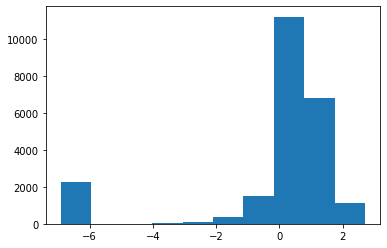

In [36]:
# Plot Y distribution
from matplotlib import pyplot as plt 

plt.hist(Y)

In [37]:
np.std(Y)

2.331205650461266

In [38]:
# check for nans
np.sum(Y)

-3033.3529798000873

In [39]:
out_comps_small.shape

(23463, 641)

In [40]:
train_out = out_comps_small.loc[:, out_comps_small.columns != 'valuation_growth']

In [41]:
train_out.shape

(23463, 640)

In [42]:
# split into train / test / dev

train_x, test_x_0, train_y, test_y_0 = train_test_split(train_out, Y, test_size = 0.3)
val_x_0, test_x, val_y_0, test_y = train_test_split(test_x_0, test_y_0, test_size = 0.333)
val_x, dev_x, val_y, dev_y = train_test_split(val_x_0, val_y_0, test_size = 0.5)


In [43]:
train_x.shape

(16424, 640)

In [44]:
test_x.shape

(2344, 640)

In [45]:
dev_x.shape

(2348, 640)

In [46]:
val_x.shape

(2347, 640)

In [96]:
np.random.seed(0)

Experiment #0
[0.006378902796357025, 0.6000000000000001, 0.05, 7, [71, 13, 87, 25, 40, 91, 74], 'leaky relu']
Train on 16424 samples, validate on 2348 samples
Epoch 1/2
16424/16424 [==============================] - 2s 113us/step - loss: 125.1719 - mean_squared_error: 106.9212 - val_loss: 17.8439 - val_mean_squared_error: 4.0225
Epoch 2/2
16424/16424 [==============================] - 1s 76us/step
Final Train Loss(MSE): 3.6976194696140707
Final Dev Loss(MSE): 2.086796458372672
Validation Loss(MSE): 1.9833296764440418


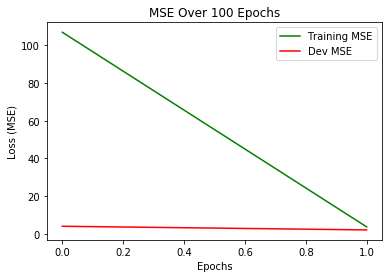


Experiment #1
[0.02147395215717599, 0.5, 0.05, 11, [13, 79, 9, 83, 68, 20, 5, 80, 75, 10, 29], 'leaky relu']
Train on 16424 samples, validate on 2348 samples
Epoch 1/2
16424/16424 [==============================] - 3s 178us/step - loss: 85.3731 - mean_squared_error: 53.5636 - val_loss: 13.3585 - val_mean_squared_error: 5.9751
Epoch 2/2
16424/16424 [==============================] - 1s 74us/step
Final Train Loss(MSE): 5.373867767123089
Final Dev Loss(MSE): 5.979717910188223
Validation Loss(MSE): 5.035457001983942


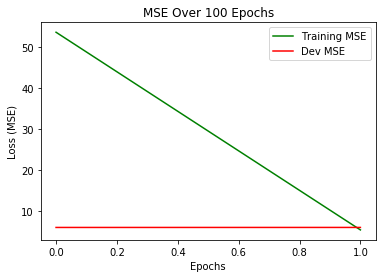


Experiment #2
[0.018031023999522257, 0.6000000000000001, 0.05, 10, [47, 86, 79, 11, 38, 53, 99, 79, 89, 51], 'leaky relu']
Train on 16424 samples, validate on 2348 samples
Epoch 1/2
16424/16424 [==============================] - 4s 217us/step - loss: 61.8868 - mean_squared_error: 12.7167 - val_loss: 10.9540 - val_mean_squared_error: 5.9900
Epoch 2/2
16424/16424 [==============================] - 1s 39us/step
Final Train Loss(MSE): 5.37381331274931
Final Dev Loss(MSE): 6.0036664504614965
Validation Loss(MSE): 5.029731907740928


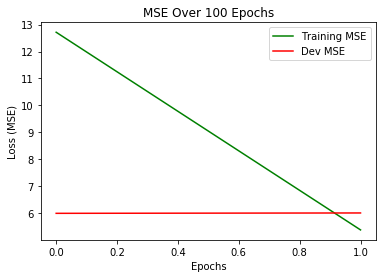


Experiment #3
[0.006263374642297805, 0.2, 0.2, 4, [76, 4, 25, 23], 'leaky relu']
Train on 16424 samples, validate on 2348 samples
Epoch 1/2
16424/16424 [==============================] - 4s 219us/step - loss: 16.1267 - mean_squared_error: 11.3846 - val_loss: 7.7806 - val_mean_squared_error: 5.7256
Epoch 2/2
16424/16424 [==============================] - 2s 137us/step
Final Train Loss(MSE): 6.077630668747907
Final Dev Loss(MSE): 3.4793598980879255
Validation Loss(MSE): 3.927256794040844


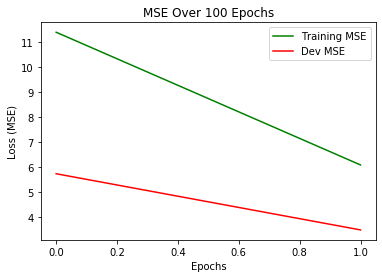


Experiment #4
[0.0001354817020244451, 0.8, 0.3, 5, [91, 76, 54, 13, 62], 'leaky relu']
Train on 16424 samples, validate on 2348 samples
Epoch 1/2
16424/16424 [==============================] - 3s 159us/step - loss: 908.4023 - mean_squared_error: 908.0022 - val_loss: 6.2566 - val_mean_squared_error: 5.9817
Epoch 2/2
16424/16424 [==============================] - 1s 49us/step
Final Train Loss(MSE): 5.784702394976014
Final Dev Loss(MSE): 3.1177412021708446
Validation Loss(MSE): 2.8453166540704182


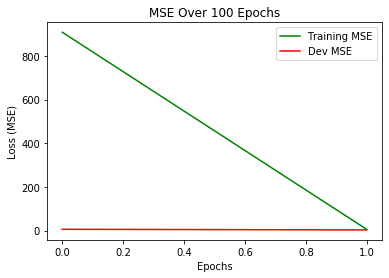


Experiment #5
[0.12942772445124082, 0.8, 0.3, 10, [20, 77, 12, 66, 31, 34, 84, 11, 80, 19], 'leaky relu']
Train on 16424 samples, validate on 2348 samples
Epoch 1/2
16424/16424 [==============================] - 7s 400us/step - loss: 255.7216 - mean_squared_error: 59.7176 - val_loss: 46.4987 - val_mean_squared_error: 5.9816
Epoch 2/2
16424/16424 [==============================] - 2s 139us/step
Final Train Loss(MSE): 5.373387721011073
Final Dev Loss(MSE): 5.983344362379136
Validation Loss(MSE): 5.0333626181915765


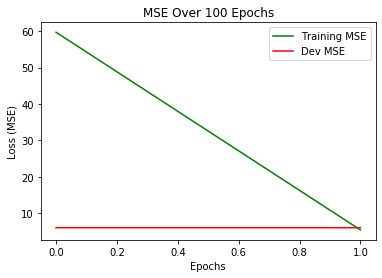


Experiment #6
[0.00026826214587144113, 0.4, 0.25, 6, [83, 84, 66, 29, 5, 79], 'leaky relu']
Train on 16424 samples, validate on 2348 samples
Epoch 1/2
16424/16424 [==============================] - 5s 303us/step - loss: 79.0406 - mean_squared_error: 78.2471 - val_loss: 6.5261 - val_mean_squared_error: 5.9510
Epoch 2/2
16424/16424 [==============================] - 1s 64us/step
Final Train Loss(MSE): 5.145557073866281
Final Dev Loss(MSE): 3.4135908357532507
Validation Loss(MSE): 3.063618155708199


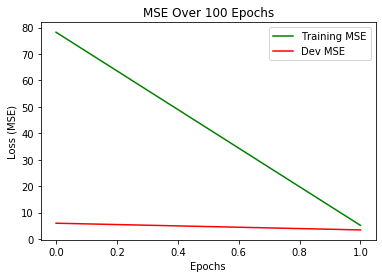


Experiment #7
[0.4951842723384213, 0.2, 0.2, 7, [27, 96, 61, 18, 27, 76, 93], 'leaky relu']
Train on 16424 samples, validate on 2348 samples
Epoch 1/2
16424/16424 [==============================] - 6s 356us/step - loss: 683.9959 - mean_squared_error: 36.5764 - val_loss: 76.0225 - val_mean_squared_error: 5.9807
Epoch 2/2
16424/16424 [==============================] - 1s 54us/step
Final Train Loss(MSE): 5.373313477488767
Final Dev Loss(MSE): 5.974478700498096
Validation Loss(MSE): 5.040296876791136


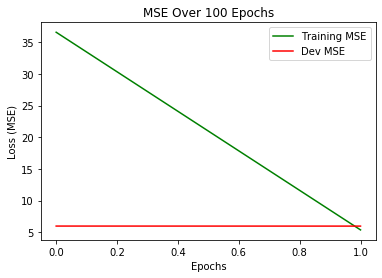


Experiment #8
[0.00032083547967249937, 0.2, 0.1, 9, [94, 12, 87, 67, 52, 89, 64, 53, 78], 'leaky relu']
Train on 16424 samples, validate on 2348 samples
Epoch 1/2
16424/16424 [==============================] - 4s 228us/step - loss: 503.8059 - mean_squared_error: 502.0124 - val_loss: 6.2402 - val_mean_squared_error: 4.7108
Epoch 2/2
16424/16424 [==============================] - 1s 52us/step
Final Train Loss(MSE): 3.6816112088158373
Final Dev Loss(MSE): 4.915587520274434
Validation Loss(MSE): 4.154307602718632


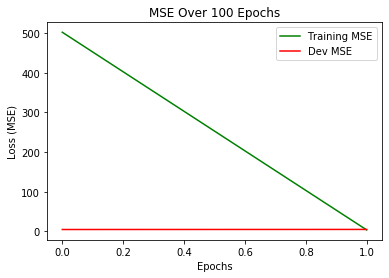


Experiment #9
[0.9088733818888882, 0.7000000000000001, 0.3, 10, [60, 26, 69, 26, 56, 63, 44, 95, 37, 97], 'leaky relu']
Train on 16424 samples, validate on 2348 samples
Epoch 1/2
16424/16424 [==============================] - 4s 215us/step - loss: 1964.0734 - mean_squared_error: 72.7182 - val_loss: 199.2788 - val_mean_squared_error: 5.9788
Epoch 2/2
16424/16424 [==============================] - 1s 59us/step
Final Train Loss(MSE): 5.373275238888123
Final Dev Loss(MSE): 5.975597375905494
Validation Loss(MSE): 5.039006681405691


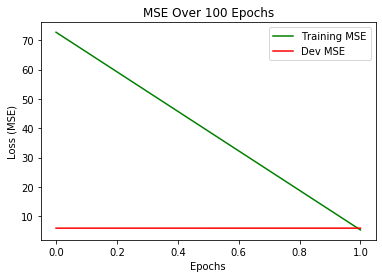


Experiment #10
[0.0008217078329819706, 0.5, 0.05, 5, [32, 93, 97, 33, 12], 'leaky relu']
Train on 16424 samples, validate on 2348 samples
Epoch 1/2
16424/16424 [==============================] - 5s 280us/step - loss: 8.5989 - mean_squared_error: 6.7304 - val_loss: 4.5518 - val_mean_squared_error: 2.8995
Epoch 2/2
16424/16424 [==============================] - 1s 90us/step
Final Train Loss(MSE): 2.587199287941789
Final Dev Loss(MSE): 2.0432095552018796
Validation Loss(MSE): 1.9061722510613732


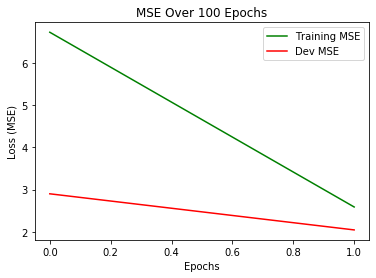


Experiment #11
[0.19007335672554088, 0.1, 0.2, 5, [59, 17, 80, 37, 75], 'leaky relu']
Train on 16424 samples, validate on 2348 samples
Epoch 1/2
16424/16424 [==============================] - 7s 449us/step - loss: 285.9842 - mean_squared_error: 64.7081 - val_loss: 44.9607 - val_mean_squared_error: 5.9845
Epoch 2/2
16424/16424 [==============================] - 1s 87us/step
Final Train Loss(MSE): 5.373321354011762
Final Dev Loss(MSE): 5.9924799872013335
Validation Loss(MSE): 5.0305085614939475


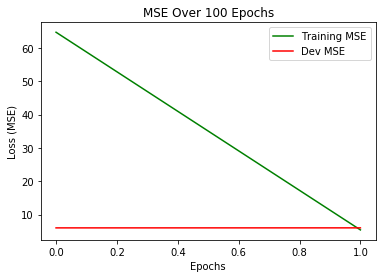


Experiment #12
[0.24174006273703263, 0.7000000000000001, 0.3, 5, [6, 7, 71, 80, 52], 'leaky relu']
Train on 16424 samples, validate on 2348 samples
Epoch 1/2
16424/16424 [==============================] - 6s 338us/step - loss: 339.0137 - mean_squared_error: 127.4810 - val_loss: 36.1948 - val_mean_squared_error: 5.9700
Epoch 2/2
16424/16424 [==============================] - 2s 128us/step
Final Train Loss(MSE): 5.371872451441264
Final Dev Loss(MSE): 5.986937310870299
Validation Loss(MSE): 5.03190762284567


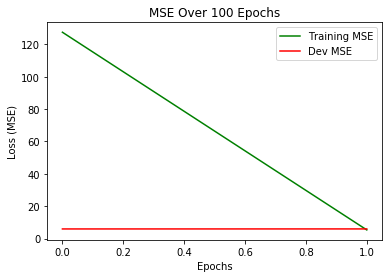


Experiment #13
[0.0007748013302863938, 0.30000000000000004, 0.05, 10, [29, 62, 30, 70, 50, 58, 81, 78, 77, 79], 'leaky relu']
Train on 16424 samples, validate on 2348 samples
Epoch 1/2
16424/16424 [==============================] - 7s 427us/step - loss: 285.8724 - mean_squared_error: 281.7397 - val_loss: 7.5773 - val_mean_squared_error: 3.7716
Epoch 2/2
16424/16424 [==============================] - 1s 80us/step
Final Train Loss(MSE): 32.67699714410729
Final Dev Loss(MSE): 1.83355407861063
Validation Loss(MSE): 1.9241721793647315


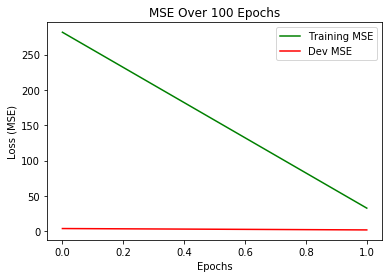


Experiment #14
[0.008794813308182051, 0.5, 0.1, 10, [32, 14, 84, 65, 30, 29, 91, 36, 8, 81], 'leaky relu']
Train on 16424 samples, validate on 2348 samples
Epoch 1/2
16424/16424 [==============================] - 7s 453us/step - loss: 24.7183 - mean_squared_error: 9.7987 - val_loss: 8.9678 - val_mean_squared_error: 5.9989
Epoch 2/2
16424/16424 [==============================] - 4s 259us/step
Final Train Loss(MSE): 5.374829779208955
Final Dev Loss(MSE): 5.996342867765151
Validation Loss(MSE): 5.029983786658932


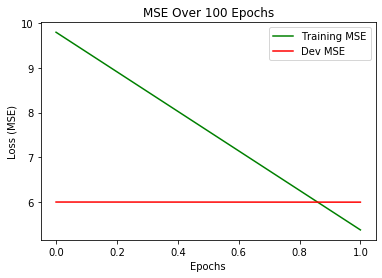

In [51]:
# training time!
num_vars = train_x.shape[1]
np.random.seed(0)
hyperparameters = []
seeds = []
MSEs = []

bs = 64 # batch size = 64
e = 100 # epochs = 100
for i in range(15):
  print("Experiment #"+str(i))
  #seed = int(np.random.rand())
  s = np.random.seed(i)
  seeds.append(s)

  choices = []
  l = -4 * np.random.rand()
  regularization = 10**l
  choices.append(regularization)
  #clipnorm
  c = 0.1 * np.random.randint(1, 9)
  choices.append(c)
  
  #dropout
  d = np.random.choice([0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
  choices.append(d)
  #num of layers
  layers = np.random.randint(4, 12)
  choices.append(layers)

  #num of hidden units per layer
  units_lst = [np.random.randint(4, 100) for i in range(layers)]
  choices.append(units_lst)

  # activations = ["leaky relu", "relu", "swish"]
  # activations = ["leaky relu", "relu"]
  activations = ["leaky relu"]
  a = np.random.choice(activations)
  choices.append(a)
  hyperparameters.append(choices)

  print(choices)
  # defining keras model
  model = Sequential()

  for i in range(layers):
    if i == 0:
      if choices[5] == 'leaky relu':
        model.add(Dense(units_lst[i], input_dim=num_vars, kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l1(choices[0])))
        model.add(LeakyReLU(alpha=0.1))
      elif choices[5] == 'relu':
        model.add(Dense(units_lst[i], input_dim=num_vars, kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l1(choices[0]), activation='relu'))
    else:
      if choices[5] == 'leaky relu':
        model.add(Dense(units_lst[i], kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l1(choices[0])))
        model.add(LeakyReLU(alpha=0.1))
      elif choices[5] == 'relu':
        model.add(Dense(units_lst[i], kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l1(choices[0]), activation='relu'))

      model.add(Dropout(choices[2]))
  
  model.add(Dense(1, activation='linear'))

  #create optimizer
  optimizer = Adam(lr=0.005, clipnorm=choices[1])

  # compile the keras model
  model.compile(loss="mse", optimizer=optimizer, metrics=["mse"])
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
  history = model.fit(train_x, train_y, validation_data = (dev_x, dev_y), epochs=e, batch_size=bs)
  
  val_loss, val_mse = model.evaluate(val_x, val_y, verbose=1)
  train_loss, train_mse = model.evaluate(train_x, train_y, verbose=1)
  print("Final Train Loss(MSE): "+str(history.history['mean_squared_error'][-1]))
  print("Final Dev Loss(MSE): "+str(history.history['val_mean_squared_error'][-1]))
  print("Validation Loss(MSE): "+str(val_mse))
  MSEs.append((train_mse, val_mse))

  epochs = range(0, e)
  train_mse = history.history['mean_squared_error']
  dev_mse = history.history['val_mean_squared_error']
  plt.plot(epochs, train_mse, 'g', label='Training MSE')
  plt.plot(epochs, dev_mse, 'r', label='Dev MSE')
  plt.title("MSE Over 100 Epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Loss (MSE)")
  plt.legend()
  plt.show()
  #Resets seed for next experiment
  np.random.seed()
  print("")

In [52]:
# Error Bar computation based on best model

num = 13

hyperparameters_best = hyperparameters[num]
hyperparameters_best

[0.0007748013302863938,
 0.30000000000000004,
 0.05,
 10,
 [29, 62, 30, 70, 50, 58, 81, 78, 77, 79],
 'leaky relu']

In [53]:
# Error Bar computation based on best model

meta_history = []

hyperparameters_best = hyperparameters[13]

np.random.seed(0)

for i in range(5):
  print("Iteration #"+str(i))
  s = np.random.seed(i)
  seeds.append(s)

  # regularization
  regularization = hyperparameters_best[0]
    
  #clipnorm
  c = hyperparameters_best[1]
  
  #dropout
  d = hyperparameters_best[2]

  #num of layers
  layers = hyperparameters_best[3]

  #num of hidden units per layer
  units_lst = hyperparameters_best[4]

  activations = hyperparameters_best[5]

  # defining keras model
  model = Sequential()

  for i in range(layers):
    if i == 0:
      if choices[5] == 'leaky relu':
        model.add(Dense(units_lst[i], input_dim=num_vars, kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l1(choices[0])))
        model.add(LeakyReLU(alpha=0.1))

    else:
      if choices[5] == 'leaky relu':
        model.add(Dense(units_lst[i], kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l1(choices[0])))
        model.add(LeakyReLU(alpha=0.1))

      model.add(Dropout(choices[2]))
  
  model.add(Dense(1, activation='linear'))
 
  #create optimizer
  optimizer = Adam(lr=0.005, clipnorm=choices[1])

  # compile the keras model
  model.compile(loss="mse", optimizer=optimizer, metrics=["mse"])
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
  history = model.fit(train_x, train_y, validation_data = [dev_x, dev_y], epochs=e, batch_size=bs)

  val_loss, val_mse = model.evaluate(val_x, val_y, verbose=1)
  train_loss, train_mse = model.evaluate(train_x, train_y, verbose=1)
  print("Final Train Loss(MSE): "+str(train_mse))
  print("Final Dev Loss(MSE): "+str(history.history['val_mean_squared_error'][-1]))
  print("Validation Loss(MSE): "+str(val_mse))

  meta_history.append(history)

Iteration #0
Train on 16424 samples, validate on 2348 samples
Epoch 1/2
16424/16424 [==============================] - 9s 549us/step - loss: 86.6646 - mean_squared_error: 54.9043 - val_loss: 13.8121 - val_mean_squared_error: 5.5682
Epoch 2/2
16424/16424 [==============================] - 2s 129us/step
Final Train Loss(MSE): 2.416204666255221
Final Dev Loss(MSE): 2.65943690702903
Validation Loss(MSE): 2.5874218818833588
Iteration #1
Train on 16424 samples, validate on 2348 samples
Epoch 1/2
16424/16424 [==============================] - 5s 287us/step - loss: 69.7921 - mean_squared_error: 34.3835 - val_loss: 22.9019 - val_mean_squared_error: 3.3713
Epoch 2/2
16424/16424 [==============================] - 3s 165us/step
Final Train Loss(MSE): 2.2849024510418445
Final Dev Loss(MSE): 2.5363666365459383
Validation Loss(MSE): 2.349611149476242
Iteration #2
Train on 16424 samples, validate on 2348 samples
Epoch 1/2
16424/16424 [==============================] - 10s 623us/step - loss: 73.0258 - 

In [59]:
meta_history[0].history['val_mean_squared_error']

[5.568177034745225, 2.65943690702903]

In [60]:
meta_history[0].history['mean_squared_error']

[54.904285578163325, 3.8851435508486474]

In [61]:
# stack MSEs

model_13_train_mses = np.column_stack([meta_history[0].history['mean_squared_error'], 
                                       meta_history[1].history['mean_squared_error'], 
                                       meta_history[2].history['mean_squared_error'], 
                                       meta_history[3].history['mean_squared_error'], 
                                       meta_history[4].history['mean_squared_error']])

model_13_val_mses = np.column_stack([meta_history[0].history['val_mean_squared_error'], 
                                       meta_history[1].history['val_mean_squared_error'], 
                                       meta_history[2].history['val_mean_squared_error'], 
                                       meta_history[3].history['val_mean_squared_error'], 
                                       meta_history[4].history['val_mean_squared_error']])


model_13_train_mses.shape

(2, 5)

In [62]:
model_13_val_mses.shape

(2, 5)

In [63]:
# mean training mse for best model

model_13_train_mse_mean = np.mean(model_13_train_mses, axis=1)

model_13_train_mse_mean.shape

(2,)

In [64]:
# mean validation mse for best model

model_13_val_mse_mean = np.mean(model_13_val_mses, axis=1)

model_13_val_mse_mean.shape

(2,)

In [65]:
# sd of training mse for best model

model_13_train_mse_sd = np.std(model_13_train_mses, axis=1)

model_13_train_mse_sd.shape

(2,)

In [66]:
# sd of validation mse for best model

model_13_val_mse_sd = np.std(model_13_val_mses, axis=1)

model_13_val_mse_sd.shape

(2,)

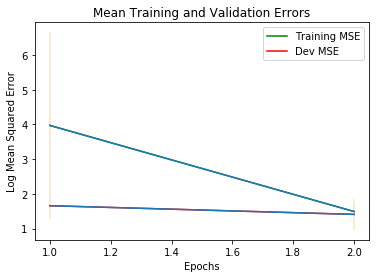

In [70]:
# Plot Mean Training + Validation Errors

x = range(1,e+1)

plt.figure()
plt.plot(x, np.log(model_13_train_mse_mean), 'g', label='Training MSE')
plt.errorbar(x, np.log(model_13_train_mse_mean), yerr=np.log(model_13_train_mse_sd), ecolor='bisque')

plt.plot(x, np.log(model_13_val_mse_mean), 'r', label='Dev MSE')
plt.errorbar(x, np.log(model_13_val_mse_mean), yerr=np.log(model_13_val_mse_sd), ecolor='bisque')

plt.title("Mean Training and Validation Errors")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Log Mean Squared Error")
plt.show()

In [71]:
# model overall standard deviation:

overall_sd = np.std([model_13_train_mse_sd, model_13_val_mse_sd])

overall_sd

5.87175601764025

In [72]:
# model training  standard deviation:

train_sd = np.std(model_13_train_mse_sd)
train_sd

6.92155026920865

In [74]:
# model validation standard deviation:

val_sd = np.std(model_13_val_mse_sd)
val_sd

0.29468010198722333

In [107]:
# Random Forest Benchmark

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42, verbose=3)

# Train the model on training data
rf.fit(train_x, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.6min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=3,
                      warm_start=False)

In [109]:
# Use the forest's predict method on the train data
predictions = rf.predict(train_x)

# Calculate the square errors
sq_errors = np.power((predictions - train_y), 2)

# Print out the mean square error (mse)
print('Mean Square Error:', np.mean(sq_errors), 'degrees.')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Mean Square Error: 0.15352700053613463 degrees.


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


In [110]:
# Use the forest's predict method on the validation data
predictions = rf.predict(val_x)

# Calculate the square errors
sq_errors = np.power((predictions - val_y), 2)

# Print out the mean square error (mse)
print('Mean Square Error:', np.mean(sq_errors), 'degrees.')

Mean Square Error: 1.1011274024292534 degrees.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [111]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_x)

# Calculate the square errors
sq_errors = np.power((predictions - test_y), 2)

# Print out the mean square error (mse)
print('Mean Square Error:', np.mean(sq_errors), 'degrees.')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Mean Square Error: 1.105051939913353 degrees.


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [112]:
# OLS Regression Benchmark

from sklearn import linear_model

lm = linear_model.Lasso(alpha=0.1)

model = lm.fit(train_x,train_y)

In [113]:
# Predict OLS (train)
predictions_ols = lm.predict(train_x)

# Calculate the square errors
sq_errors_ols = np.power((predictions_ols - train_y), 2)

# Print out the mean square error (mse)
print('Mean Square Error OLS:', np.mean(sq_errors_ols))

Mean Square Error OLS: 2.452791911419779


In [114]:
# Predict OLS (validation)
predictions_ols_2 = lm.predict(val_x)

# Calculate the square errors
sq_errors_ols_2 = np.power((predictions_ols_2 - val_y), 2)

# Print out the mean square error (mse)
print('Mean Square Error OLS, val:', np.mean(sq_errors_ols_2))

Mean Square Error OLS, val: 2.3394399379439665


In [115]:
# Predict OLS (test)
predictions_ols_3 = lm.predict(test_x)

# Calculate the square errors
sq_errors_ols_3 = np.power((predictions_ols_3 - test_y), 2)

# Print out the mean square error (mse)
print('Mean Square Error OLS, val:', np.mean(sq_errors_ols_3))

Mean Square Error OLS, val: 2.4415265914644015
